# **Optimal Preconditioner Problem**

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.sparse.linalg import gmres
from scipy.linalg import hilbert, invhilbert
import scipy.sparse as sp
import time
from scipy.linalg import svd
import matplotlib.pyplot as plt

# ToDos / Ideas
- [ ] Usar un método de optimización que use gradiente y pre calcular el gradiente analitico seguramente va a disminuir el tiempo de computo del precondicionador.
- [ ] Ide de en lugar de intentar llegar a una identidad usar pesos y llegar a una triangular inferior

## **Funciones Auxiliares**

In [19]:
def debug(msg,verbose=True):
    if verbose:
        print(msg)
    else:
        pass


def is_valid_M_structure(config):
    valid_structure = np.array(["k-diagonal", "k-triangular-low"])
    return 'M-structure' in config and np.isin(config['M-structure'], valid_structure)

def is_valid_A_structure(config):
    valid_structure = np.array(["dense", "sparse", "k-triangular-low", "k-triangular-up","k-diagonal", "hilbert"])
    return 'A-structure' in config and np.isin(config['A-structure'], valid_structure)

def is_valid_multiplication_mode(config):
    valid_modes = np.array(["left-multiplication", "both-sides-multiplication"])
    return 'multiplication-mode' in config and np.isin(config['multiplication-mode'], valid_modes)


def num_elements_M(n,k,structure):
    if structure == "k-triangular-low":
        sum = (k)*n
        res = (k*(k-1))/2
        return sum-res
    elif structure == "k-diagonal":
        sum = 2*n*(k-1) + n
        res = (k-1)*(k)
        return int(sum-res)
    

def is_valid_values(n,k,len,structure):
    expected_elements = num_elements_M(n,k,structure)
    if structure == "k-triangular-low":
        valid =  expected_elements == len and k>0 and k<=n and n>=3
        return valid
    elif structure == "k-diagonal":
        valid = expected_elements == len and k>0 and k<=n and n>=3
        return valid


def validate_M_config(M_config):
    if not is_valid_M_structure(M_config):
        raise TypeError("Error en la variable config['M-structure']")

    if 'n' not in M_config or not isinstance(M_config['n'], int):
        raise TypeError("El 'config' debe contener 'n' como un entero (int).")

    if 'k' not in M_config or not isinstance(M_config['k'], int):
        raise TypeError("El 'config' debe contener 'k' como un entero (int).")

    if not is_valid_multiplication_mode(M_config):
        raise TypeError("El 'config' debe contener 'multiplication-mode' como un string (string)")
    
    if 'seed' not in M_config or not isinstance(M_config['seed'], int):
        raise TypeError("El 'config' debe contener 'seed' como un entero (int).")
    
    if 'optimization-mode' not in M_config or not isinstance(M_config['optimization-mode'], str):
        raise TypeError("El 'config' debe contener 'optimization-mode' como un string (str).")
    
    if 'tol' not in M_config or not isinstance(M_config['tol'], float):
        raise TypeError("El 'config' debe contener 'tol' como un float (float).")	
    

def validate_A_config(A_config):
    #k is optional
    if not is_valid_A_structure(A_config):
        raise TypeError("Error en la variable config['A-structure']")

    if 'n' not in A_config or not isinstance(A_config['n'], int):
        raise TypeError("El 'config' debe contener 'n' como un entero (int).")

    if 'seed' not in A_config or not isinstance(A_config['seed'], int):
        raise TypeError("El 'config' debe contener 'seed' como un entero (int).")
    
    # if 'density' not in A_config or not isinstance(A_config['density'], float):
        # raise TypeError("El 'config' debe contener 'density' como un float (float).")	

    if 'diagonally-dominant' not in A_config or not isinstance(A_config['diagonally-dominant'], bool):
        raise TypeError("El 'config' debe contener 'diagonally-dominant' como un bool (bool).")	

## **Contrucción matrices $M$, $A$**

In [20]:
def build_M(M_values, M_config):
    structure = M_config["M-structure"]
    n = M_config["n"]
    k = M_config["k"]
    # ::===========================  SANITY CHECKS ===========================::
    if not is_valid_values(n,k,len(M_values),structure):
        raise ValueError("La matriz de valores tiene un problema, ")
    # debug("Verificaciones de configuración completadas con éxito")
    # ::===========================  SANITY CHECKS ===========================::


    # ::======================  CASE: k-triangular-low  ======================::
    M = np.zeros((n, n))
    if structure == "k-triangular-low":
        values_temp = M_values.copy()
        start = 0
        for offset in range(k):
            length = n - offset
            diag = values_temp[start:start + length]
            start += length
            np.fill_diagonal(M[offset:, :n - offset], diag)
    # ::======================  CASE: k-triangular-low  ======================::

    # ::=========================  CASE: k-diagonal  =========================::
    elif structure == "k-diagonal":
        values_temp = M_values.copy()
        diagonals = list(range(k-1, -k, -1))   
        start = 0 
        for k in diagonals:
            length = n - abs(k)
            if start >= len(values_temp) or length <= 0:
                break
            end = start + length
            diag_values = values_temp[start:end]
            start = end
            if k >= 0:
                rows = np.arange(length)
                cols = np.arange(k, k + length)
            else:
                # Diagonales inferiores
                rows = np.arange(-k, -k + length)
                cols = np.arange(length)

            M[rows, cols] = diag_values
    # ::=========================  CASE: k-diagonal  =========================::
    
    return M

In [21]:
def adjust_condition_number(A, cond_num):
    U, s, Vt = svd(A)
    s_min = s[-1]
    s_max = s[0]
    
    if s_max / s_min < cond_num:
        s_new = np.linspace(s_max, s_max / cond_num, len(s))
    else:
        s_new = (s - s_min) / (s_max - s_min) * (s_max - s_max/cond_num) + s_max/cond_num
    
    A_cond = U @ np.diag(s_new) @ Vt
    return A_cond

def build_A(A_config):
    # PARAMETERS EXTRACTION 
    seed = A_config["seed"]
    n = A_config["n"]
    structure = A_config["A-structure"]
    cond_number = A_config["cond_number"]
    diagonal_dominant = A_config["diagonally-dominant"]
    np.random.seed(seed=seed)
    

    A = np.zeros((n,n))
    
    # ::=========================  CASE: DENSE  =========================::
    if structure == "dense":
        A_rand = np.random.rand(n,n)
        A = A + A_rand + np.eye(n)
    # ::=========================  CASE: DENSE  =========================::
    
    # ::=========================  CASE: SPARSE =========================::
    elif structure == 'sparse':
        density = A_config["density"]
        A_rand = sp.random(n, n, density=density, random_state=seed).toarray()
        A = A + A_rand + np.eye(n)
    # ::=========================  CASE: SPARSE =========================::

    # ::=======================  CASE: K-DIAGONAL  =======================::
    elif structure == 'k-diagonal':
        k = A_config["k"]
        max_offset = k - 1
        for offset in range(-max_offset, max_offset + 1):
             longitud_diag = n - abs(offset)
             valores_aleatorios = np.random.rand(longitud_diag)
             A += np.diag(valores_aleatorios, k=offset)
    # ::=======================  CASE: K-DIAGONAL  =======================::

    # ::======================  CASE: K-TRIANGULAR  ======================::
    elif structure == 'k-triangular-low' or structure == 'k-triangular-up':
        k = A_config["k"]
        for offset in range(0, -k, -1):
            longitud_diag = n - abs(offset)
            valores_aleatorios = np.random.rand(longitud_diag)
            A += np.diag(valores_aleatorios, k=offset)
        if structure == 'k-triangular-up':
            A = A.T
    # ::======================  CASE: K-TRIANGULAR  ======================::

    # ::======================  CASE: HILBERT  ==========================::
    elif structure == 'hilbert':
        A = hilbert(n)
    # ::======================  CASE: HILBERT  =========================::


    if diagonal_dominant:
        row_sums = np.sum(np.abs(A), axis=1)
        np.fill_diagonal(A, row_sums + np.random.rand(n) + 0.1)
        
    if cond_number is not None and cond_number > 1:
        A = adjust_condition_number(A, cond_number)

    return A

## **Función Objetivo**

In [22]:
def objective_fun(M_values, A, M_config):
    n = M_config["n"]
    M = build_M(M_values,M_config)
    multiplication_mode = M_config["multiplication-mode"]
    objective_structure = M_config["objective-structure"]

    if multiplication_mode == "left-multiplication":
        diff = M @ A - np.eye(n)
    elif multiplication_mode == "both-sides-multiplication":
        diff = M @ A @ M.T - np.eye(n)
    
        
    if objective_structure == "identity":
        return np.linalg.norm(diff, 'fro')
    elif objective_structure =="triangular-low":
        # W = np.diag(np.ones(n)) 
        W = np.ones((n,n))
        index_upper = np.triu_indices(n,k=1)
        penalty_weight = 1e6
        W[index_upper] = penalty_weight
        # print(f"Matriz de Pesos W: \n {W}")
        weighted_diff = W * diff
        # print(f"W * diff: \n {W * diff}")
        return np.linalg.norm(weighted_diff, 'fro')

In [23]:
def optimizer(A, M_config, x0):
    res = minimize(
        fun=objective_fun,
        x0=x0,
        args=(A,M_config), 
        method=M_config["optimization-mode"],
        tol=M_config["tol"]
    )        
    return res.x

# **Correr 1 experimento:**

In [24]:
def run_experiment(experiment_config, M_config, A_config, optimizer, verbose):
    n = M_config["n"]
    tol = M_config["tol"]
    repetitions = experiment_config["repetition-per-experiment"]
    multiplication_mode = M_config["multiplication-mode"]

    debug("Iniciando Experimento", verbose)
    # Construir sistema    
    A = build_A(A_config=A_config)
    x_true = np.random.rand(n)
    x0 = np.zeros(n)
    b = A @ x_true
    elements_M = num_elements_M(n,M_config["k"],M_config["M-structure"])

    debug("Optimizando precondicionador M...", verbose)
    timer_M_start = time.perf_counter()
    m0 = np.ones(int(elements_M))
    m_values = optimizer(A,M_config, m0)
    M = build_M(m_values, M_config)
    timer_M_end = time.perf_counter()
    time_build_M = timer_M_end - timer_M_start
    debug(f"Precondicionador M construido en {time_build_M:.4f} segundos.", verbose)

    debug(f"Matriz A:\n {np.round(A,2)}", verbose)
    debug(f"Matriz M:\n {np.round(M,2)}", verbose)
    debug(f"M@A considerando que estructura objetivo es {M_config["objective-structure"]}\n {np.round(M @ A,2)}")

    debug(f"Ejecutando GMRES SIN precondicionador ({repetitions} repeticiones)...", verbose)
    witout_precon_times = []
    histories_without_precon = []

    for i in range(repetitions):
        history_gmres_without_M = []
        def callback_without(rk_norm):
            return history_gmres_without_M.append(rk_norm)
        
        timer_gmres_without_M_start = time.perf_counter()
        x_without_precon, info_without = gmres(A, b, x0=x0, rtol=tol, 
                                               callback=callback_without, 
                                               callback_type='pr_norm')
        timer_gmres_without_M_end = time.perf_counter()
        
        witout_precon_times.append(timer_gmres_without_M_end - timer_gmres_without_M_start)
        histories_without_precon.append(history_gmres_without_M)

    avg_time_without_precon = np.mean(witout_precon_times)
    error_without = np.linalg.norm(x_without_precon - x_true)

    debug(f"Ejecutando GMRES CON precondicionador ({repetitions} repeticiones)...", verbose)
    with_precon_times = []
    histories_with_precon = []
    x_with_precon = None
    error_with = None    
    if multiplication_mode == "left-multiplication":
        MA = M @ A
        Mb = M @ b
        for i in range(repetitions):
            history_gmres_with_M = []
            def callback_with(rk_norm):
                history_gmres_with_M.append(rk_norm)
            
            timer_gmres_wit_M_start = time.perf_counter()
            x_with_precon, info_with = gmres(MA, Mb, x0=x0, rtol=tol, 
                                             callback=callback_with, 
                                             callback_type='pr_norm')
            timer_gmres_wit_M_end = time.perf_counter()
            
            with_precon_times.append(timer_gmres_wit_M_end - timer_gmres_wit_M_start)
            histories_with_precon.append(history_gmres_with_M)
        
        error_with = np.linalg.norm(x_with_precon - x_true)
    
    elif multiplication_mode == "both-sides-multiplication":
        # Resolver (M*A*M.T) * y = M*b, donde x = M.T * y
        MAMt = M @ A @ M.T
        Mb = M @ b
        y0 = np.zeros(n) 
        
        for i in range(repetitions):
            history_gmres_with_M = []
            def callback_with(rk_norm):
                history_gmres_with_M.append(rk_norm)

            timer_gmres_wit_M_start = time.perf_counter()
            y_solution, info_with = gmres(MAMt, Mb, x0=y0, rtol=tol, 
                                          callback=callback_with, 
                                          callback_type='pr_norm')
            timer_gmres_wit_M_end = time.perf_counter()
            
            x_with_precon = M.T @ y_solution
            
            with_precon_times.append(timer_gmres_wit_M_end - timer_gmres_wit_M_start)
            histories_with_precon.append(history_gmres_with_M)
        
        error_with = np.linalg.norm(x_with_precon - x_true)

    avg_time_with_precon = np.mean(with_precon_times)


    results = {
        "time_build_M": time_build_M,
        "avg_time_without_precon": avg_time_without_precon,
        "avg_time_with_precon": avg_time_with_precon,
        "error_without_precon": error_without,
        "error_with_precon": error_with,
        "speedup": avg_time_without_precon / avg_time_with_precon,
        "history_without": histories_without_precon[0],
        "history_with": histories_with_precon[0],
        "iterations_without": len(histories_without_precon[0]),
        "iterations_with": len(histories_with_precon[0])
    }
    
    return results

def plot_results(results):
    layout = [
        ["main_plot", "time_bar"],
        ["main_plot", "error_bar"],
    ]
    
    fig, axd = plt.subplot_mosaic(layout, 
                                  figsize=(15, 8), 
                                  width_ratios=[2, 1]) # El plot principal es 2x más ancho
    
    
    # --- 2. Panel Principal: Historial de Convergencia ---
    ax = axd["main_plot"]
    
    # Graficar historial SIN precondicionador
    hist_without = results["history_without"]
    # (Hacerlo robusto por si converge en 0 iteraciones)
    if len(hist_without) > 0:
        ax.plot(range(1, len(hist_without) + 1), hist_without, 'bo-', 
                 label=f'Sin Precondicionador ({results["iterations_without"]} iters)')
    else:
        ax.plot([], [], 'bo-', label='Sin Precondicionador (0 iters)') # Plot vacío
        
    # Graficar historial CON precondicionador
    hist_with = results["history_with"]
    if len(hist_with) > 0:
        ax.plot(range(1, len(hist_with) + 1), hist_with, 'rs-', 
                 label=f'Con Precondicionador ({results["iterations_with"]} iters)')
    else:
        ax.plot([], [], 'rs-', label='Con Precondicionador (0 iters)')
    
    ax.set_xlabel('Iteración de GMRES')
    ax.set_ylabel('Norma del Residuo (log)')
    ax.set_title('Historial de Convergencia de GMRES')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, which="both", ls="--", alpha=0.5)

    
    # --- 3. Panel Secundario: Tiempos Promedio ---
    ax_time = axd["time_bar"]
    categories = ["Sin M", "Con M"]
    colors = ['#4c72b0', '#c44e52'] # Azul y Rojo suaves
    
    times = [results["avg_time_without_precon"], results["avg_time_with_precon"]]
    
    bars_time = ax_time.bar(categories, times, color=colors)
    ax_time.set_ylabel("Tiempo promedio (s)")
    ax_time.set_title("Tiempo de Solución (GMRES)")
    
    # Añadir etiquetas de texto sobre las barras
    for bar in bars_time:
        height = bar.get_height()
        ax_time.text(bar.get_x() + bar.get_width()/2.0, height,
                     f'{height:.4f}s', 
                     ha='center', va='bottom', fontsize=9)

                     
    # --- 4. Panel Secundario: Errores Finales ---
    ax_error = axd["error_bar"]
    errors = [results["error_without_precon"], results["error_with_precon"]]
    
    bars_error = ax_error.bar(categories, errors, color=colors)
    ax_error.set_ylabel("Error Final (log)")
    ax_error.set_title("Error Final (vs $x_{true}$)")
    ax_error.set_yscale('log') # El error casi siempre es mejor en log
    
    # Añadir etiquetas de texto sobre las barras
    for bar in bars_error:
        height = bar.get_height()
        ax_error.text(bar.get_x() + bar.get_width()/2.0, height,
                     f'{height:.2e}', 
                     ha='center', va='bottom', fontsize=9)

                     
    # --- 5. Título General ---
    speedup = results["speedup"]
    time_M = results["time_build_M"]
    fig.suptitle(f"Análisis del Precondicionador (Speedup: {speedup:.2f}x)\n"
                 f"Tiempo de construcción de M: {time_M:.4f}s", 
                 fontsize=16)
    
    
    # --- 6. Mostrar Figura ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el suptitle
    
    # Guardar en archivo (útil para scripts)
    plt.savefig("experiment_results.png")
    print("Gráfica de resultados guardada en 'experiment_results.png'")
    
    # Mostrar interactivamente
    plt.show()

Iniciando Experimento
Optimizando precondicionador M...
Precondicionador M construido en 0.1061 segundos.
Matriz A:
 [[5.08 0.86 0.69 0.33 0.06 0.39 0.21]
 [0.93 5.14 0.05 0.82 0.59 0.25 0.32]
 [0.19 0.35 3.7  0.01 0.41 0.41 0.04]
 [0.96 0.4  0.53 5.18 0.31 0.55 0.71]
 [0.95 0.6  0.4  0.35 5.54 0.3  0.54]
 [0.96 0.18 0.73 0.73 0.05 5.54 0.37]
 [0.71 0.27 0.25 0.3  0.14 0.98 4.67]]
Matriz M:
 [[ 0.19  0.    0.    0.    0.    0.    0.  ]
 [-0.04  0.19  0.    0.    0.    0.    0.  ]
 [-0.01 -0.02  0.27  0.    0.    0.    0.  ]
 [-0.03 -0.01 -0.02  0.19  0.    0.    0.  ]
 [-0.03 -0.02 -0.01 -0.01  0.18  0.    0.  ]
 [ 0.   -0.01 -0.03 -0.03 -0.    0.18  0.  ]
 [ 0.    0.   -0.01 -0.01 -0.01 -0.04  0.22]]
M@A considerando que estructura objetivo es identity
 [[ 0.94  0.16  0.13  0.06  0.01  0.07  0.04]
 [-0.01  0.96 -0.02  0.15  0.11  0.03  0.05]
 [-0.   -0.01  0.98 -0.02  0.1   0.1   0.  ]
 [-0.01 -0.01 -0.01  0.98  0.04  0.08  0.12]
 [-0.   -0.   -0.   -0.01  0.99  0.03  0.08]
 [ 0.13 -0

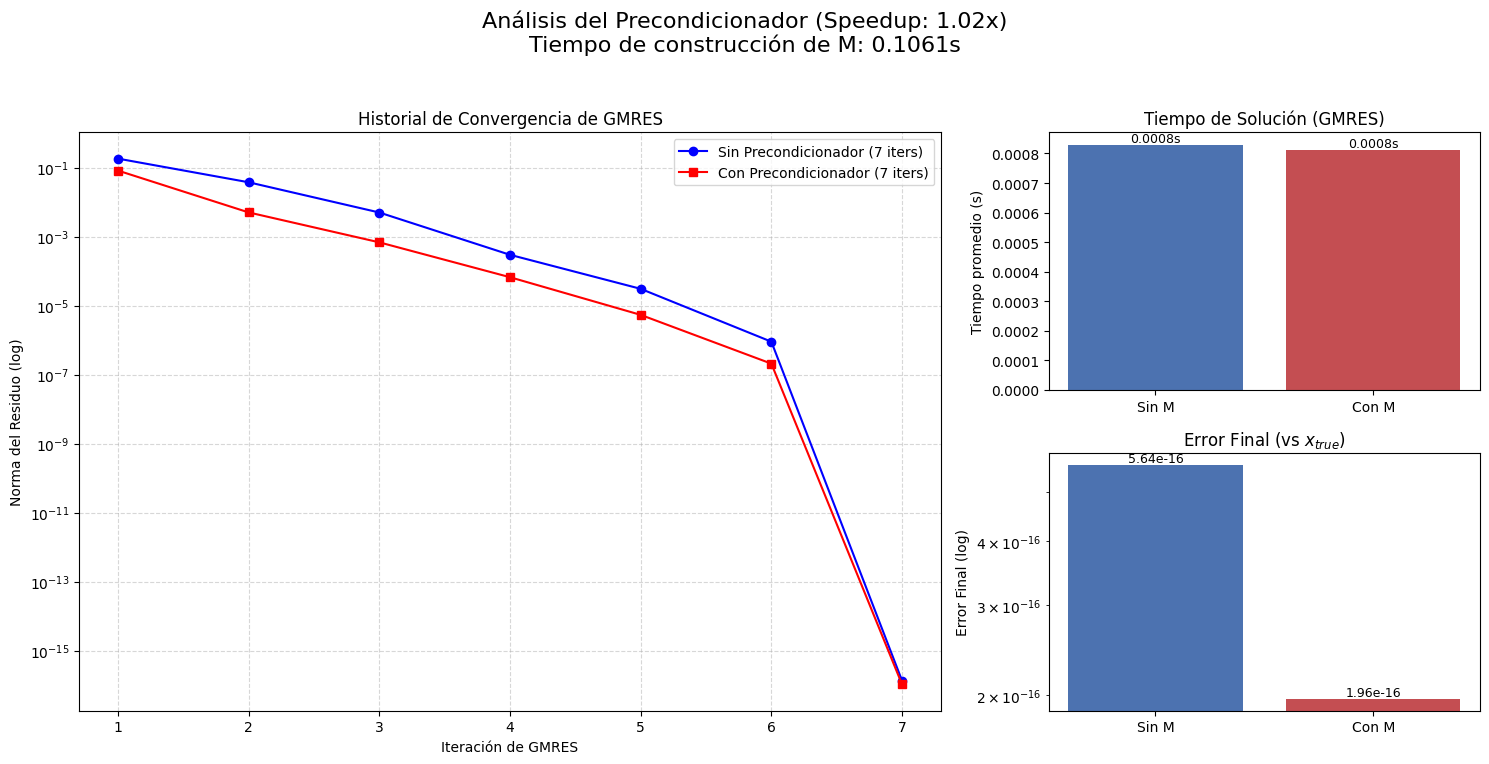

In [25]:
experiment_config ={
    "tol": 1e-8,
    "n": 7,
    "seed":67,
    "repetition-per-experiment": 5
}

M_config = {
    "M-structure":"k-triangular-low",
    # "multiplication-mode":"both-sides-multiplication",
    "multiplication-mode": "left-multiplication",
    # "objective-structure": "triangular-low",
    "objective-structure": "identity",
    "optimization-mode":"BFGS",
    "seed":experiment_config["seed"],
    "n":experiment_config["n"],
    "k":5,
    "tol":experiment_config["tol"]
}

A_config = {
    "n":experiment_config["n"],
    "k":3,
    "seed":experiment_config["seed"],
    "cond_number":None,
    "A-structure": "dense",
    "density":0.5, # solo considerado para structure "sparse"
    "diagonally-dominant": True
}


results = run_experiment(experiment_config,M_config,A_config,optimizer, verbose=True)
plot_results(results)

# Hilbert Experiment

Iniciando Experimento
Optimizando precondicionador M...
Precondicionador M construido en 34.3474 segundos.
Matriz A:
 [[1.   0.5  0.33 0.25 0.2  0.17 0.14 0.12 0.11 0.1  0.09 0.08 0.08 0.07
  0.07 0.06 0.06 0.06 0.05 0.05]
 [0.5  0.33 0.25 0.2  0.17 0.14 0.12 0.11 0.1  0.09 0.08 0.08 0.07 0.07
  0.06 0.06 0.06 0.05 0.05 0.05]
 [0.33 0.25 0.2  0.17 0.14 0.12 0.11 0.1  0.09 0.08 0.08 0.07 0.07 0.06
  0.06 0.06 0.05 0.05 0.05 0.05]
 [0.25 0.2  0.17 0.14 0.12 0.11 0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06
  0.06 0.05 0.05 0.05 0.05 0.04]
 [0.2  0.17 0.14 0.12 0.11 0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06 0.06
  0.05 0.05 0.05 0.05 0.04 0.04]
 [0.17 0.14 0.12 0.11 0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06 0.06 0.05
  0.05 0.05 0.05 0.04 0.04 0.04]
 [0.14 0.12 0.11 0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06 0.06 0.05 0.05
  0.05 0.05 0.04 0.04 0.04 0.04]
 [0.12 0.11 0.1  0.09 0.08 0.08 0.07 0.07 0.06 0.06 0.06 0.05 0.05 0.05
  0.05 0.04 0.04 0.04 0.04 0.04]
 [0.11 0.1  0.09 0.08 0.08 0.07 0.07 0.06 

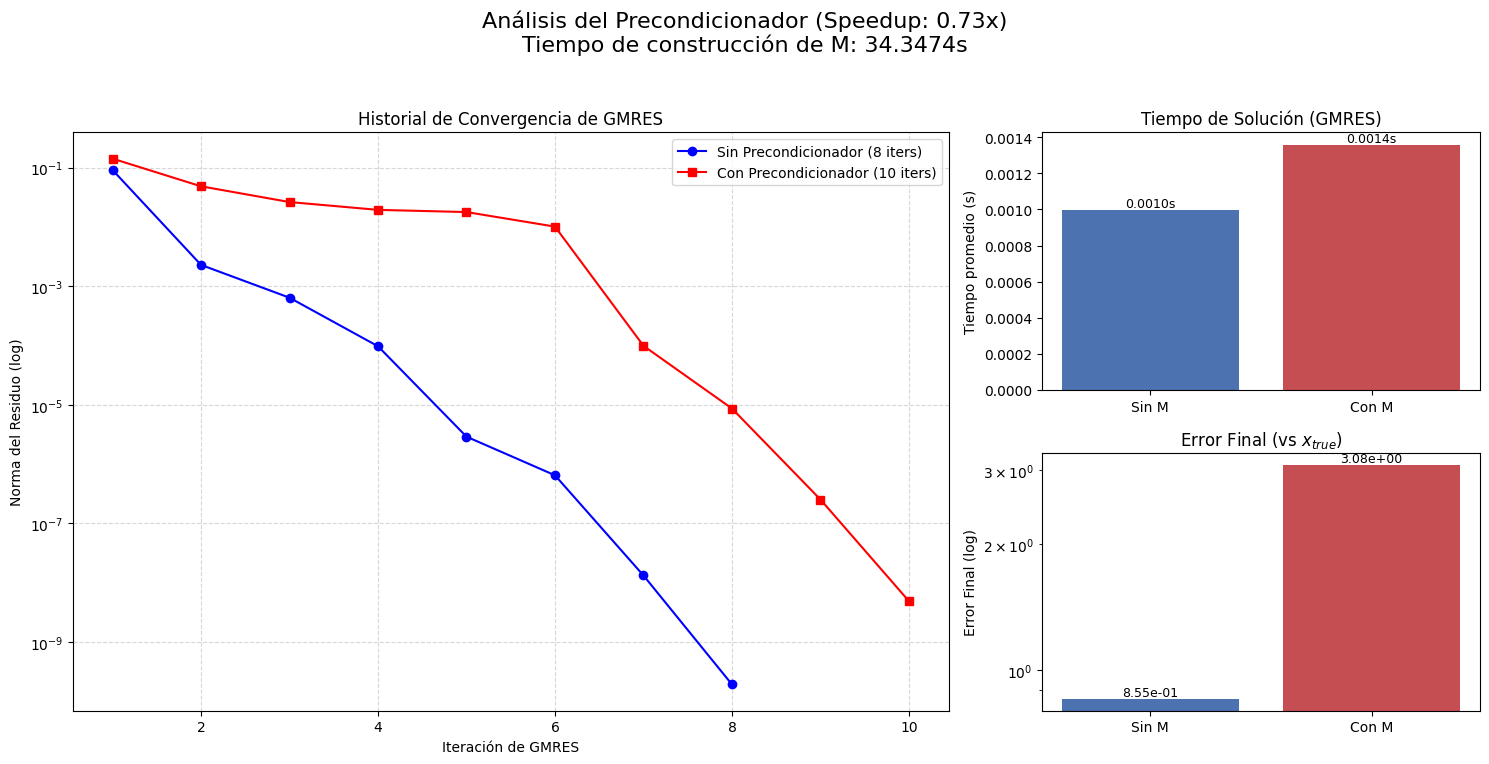

In [26]:
experiment_config ={
    "tol": 1e-8,
    "n": 20,
    "seed":67,
    "repetition-per-experiment": 5
}

M_config = {
    "M-structure":"k-triangular-low",
    # "multiplication-mode":"both-sides-multiplication",
    "multiplication-mode": "left-multiplication",
    # "objective-structure": "triangular-low",
    "objective-structure": "identity",
    "optimization-mode":"BFGS",
    "seed":experiment_config["seed"],
    "n":experiment_config["n"],
    "k":20,
    "tol":experiment_config["tol"]
}

A_config = {
    "n":experiment_config["n"],
    "k":3, # en el caso de la hilbert no se usa
    "seed":experiment_config["seed"],
    "cond_number":None,
    "A-structure": "hilbert",
    "density":0.5, # solo considerado para structure "sparse"
    "diagonally-dominant": False
}


results = run_experiment(experiment_config,M_config,A_config,optimizer, verbose=True)
plot_results(results)